In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
"""rom xgboost import XGBClassifier"""
from sklearn.multioutput import MultiOutputClassifier

In [2]:
# Read the datafile
df = pd.read_csv("VAW.csv", na_values=[" ", "_T: Any"], encoding="utf-8")

In [3]:
df=df[::56]

In [4]:
df

,DATAFLOW,FREQ: Frequency,TIME_PERIOD: Time,GEO_PICT: Pacific Island Countries and territories,TOPIC: Topic,INDICATOR: Indicator,SEX: Sex,AGE: Age,CONDITION: Women’s condition,VIOLENCE_TYPE: Type of violence,...,OUTCOME: Outcome,RESPONSE: Response,HELP_REASON: Reason for searching help,HELP_PROVIDER: Help provider,OBS_VALUE,UNIT_MEASURE: Unit of measure,UNIT_MULT: Unit multiplier,OBS_STATUS: Observation Status,DATA_SOURCE: Data source,OBS_COMMENT: Comment
0,SPC:DF_VAW(1.0),A: Annual,2013,CK: Cook Islands,VAW_TOPIC_001: Types of violence against women...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,EVPART: Ever-partnered,CONT_ECON: At least one act of economic abusive,...,NaN,NaN,NaN,NaN,85.0,PERCENT: percent,NaN,NaN,FHSS,NaN
56,SPC:DF_VAW(1.0),A: Annual,2013,CK: Cook Islands,VAW_TOPIC_008: Non-Partner Physical violence b...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,NaN,PHYS: Physical violence,...,NaN,NaN,NaN,NaN,16.5,PERCENT: percent,NaN,NaN,FHSS,NaN
112,SPC:DF_VAW(1.0),A: Annual,2013,CK: Cook Islands,VAW_TOPIC_016: Responses to partner violence -...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,NaN,NaN,...,NaN,NEVER: Never told anyone about the violence,NaN,NaN,28.3,PERCENT: percent,NaN,NaN,FHSS,NaN
168,SPC:DF_VAW(1.0),A: Annual,2011,FJ: Fiji,VAW_TOPIC_006: Acts of controlling behaviours ...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,EVPART: Ever-partnered,CONT_WHERE: Partner insists on knowing where s...,...,NaN,NaN,NaN,NaN,98.0,PERCENT: percent,NaN,O: Missing value,Fiji VAW report 2010-2011,Women age 18-64 years.
224,SPC:DF_VAW(1.0),A: Annual,2011,FJ: Fiji,VAW_TOPIC_014: Impact of partner violence on w...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,W4M: Working for money,NaN,...,CONCENTRATE: Unable to concentrate on their wo...,NaN,NaN,NaN,28.7,PERCENT: percent,NaN,NaN,Fiji VAW report 2010-2011,Women age 18-64 years.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23912,SPC:DF_VAW(1.0),A: Annual,2007,TV: Tuvalu,VAW_TOPIC_014: Impact of partner violence on w...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,W4M: Working for money,NaN,...,CONCENTRATE: Unable to concentrate on their wo...,NaN,NaN,NaN,98.0,PERCENT: percent,NaN,O: Missing value,DHS,Ever married women 15-49.
23968,SPC:DF_VAW(1.0),A: Annual,2011,VU: Vanuatu,VAW_TOPIC_004: Acts of sexual violence by part...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,EVPART: Ever-partnered,SEX_FORCE: Physically forced to have sexual in...,...,NaN,NaN,NaN,NaN,98.0,PERCENT: percent,NaN,O: Missing value,Vanuatu 2011 National Survey on Women's Lives ...,UN Women: Global database on Violence against ...
24024,SPC:DF_VAW(1.0),A: Annual,2011,VU: Vanuatu,VAW_TOPIC_012: Impact of partner violence on w...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,NaN,NaN,...,HEALTHAFF: Affected their health,NaN,NaN,NaN,46.0,PERCENT: percent,NaN,NaN,Vanuatu 2011 National Survey on Women's Lives ...,UN Women: Global database on Violence against ...
24080,SPC:DF_VAW(1.0),A: Annual,2006,WS: Samoa,VAW_TOPIC_003: Act of physical violence by par...,NUMPERRF: Number of persons in relative frequency,F: Female,Y15T64: 15-64,EVPART: Ever-partnered,PHYS_FIST: Hit with a fist or something else,...,NaN,NaN,NaN,NaN,9.4,PERCENT: percent,NaN,NaN,FHSS,Women 15-49.


#### Preprocessing

In [5]:
df.columns = df.columns.map(lambda x : x.split(":")[0])

In [6]:
df.replace(to_replace=r"\:(.*)", value="", inplace=True, regex=True)

In [7]:
df["TIME_PERIOD"] = pd.to_datetime(arg=df["TIME_PERIOD"], format="%Y")
df["OBS_VALUE"] = pd.to_numeric(arg=df["OBS_VALUE"])

object_colnames = df.select_dtypes(include="object").columns
df[object_colnames] = df[object_colnames].astype("category")

In [8]:
df.head(5)

,DATAFLOW,FREQ,TIME_PERIOD,GEO_PICT,TOPIC,INDICATOR,SEX,AGE,CONDITION,VIOLENCE_TYPE,...,OUTCOME,RESPONSE,HELP_REASON,HELP_PROVIDER,OBS_VALUE,UNIT_MEASURE,UNIT_MULT,OBS_STATUS,DATA_SOURCE,OBS_COMMENT
0,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,CONT_ECON,...,NaN,NaN,NaN,NaN,85.0,PERCENT,NaN,NaN,FHSS,NaN
56,SPC,A,2013-01-01,CK,VAW_TOPIC_008,NUMPERRF,F,Y15T64,NaN,PHYS,...,NaN,NaN,NaN,NaN,16.5,PERCENT,NaN,NaN,FHSS,NaN
112,SPC,A,2013-01-01,CK,VAW_TOPIC_016,NUMPERRF,F,Y15T64,NaN,NaN,...,NaN,NEVER,NaN,NaN,28.3,PERCENT,NaN,NaN,FHSS,NaN
168,SPC,A,2011-01-01,FJ,VAW_TOPIC_006,NUMPERRF,F,Y15T64,EVPART,CONT_WHERE,...,NaN,NaN,NaN,NaN,98.0,PERCENT,NaN,O,Fiji VAW report 2010-2011,Women age 18-64 years.
224,SPC,A,2011-01-01,FJ,VAW_TOPIC_014,NUMPERRF,F,Y15T64,W4M,NaN,...,CONCENTRATE,NaN,NaN,NaN,28.7,PERCENT,NaN,NaN,Fiji VAW report 2010-2011,Women age 18-64 years.


In [9]:
# Dataframe without missing values on OUTCOME

df_train = df.dropna(subset=["OUTCOME"]).copy()

#### Some more preprocessing to discard columns with NA's

In [10]:
# Filter features > 80% NA's

print("Keep columns that have at least", np.int16(df_train.shape[0]*.2), "non NA rows")
df_train = df_train.dropna(axis=1, thresh=np.int16(df_train.shape[0]*.2)).copy()

Keep columns that have at least 24 non NA rows


In [11]:
# Omit columns that have the same value in all rows

df_train = df_train[df_train.columns[df_train.nunique() > 1]]

In [12]:
# Drop time period
year_df_train = pd.concat([df["TIME_PERIOD"], df["OUTCOME"], df["OBS_VALUE"]],axis=1, ignore_index=False)

df_train = df_train.drop(columns=["TIME_PERIOD"])

In [13]:
X, y = df_train.drop(columns=["OUTCOME"]), df_train["OUTCOME"]

In [14]:
# Condense categories to just the 5 most important

#map_new_cat_s = {"Health" : ['HEALTHAFF', 'HEALTHSTA', 'HURT', 'INJ', 'LOSCONS', 'PAIN',
#                            'PROBMEM', 'PROBUSUAL', 'PROBWALK'],
#                        "Children" : ['AL1CHILDAGGR', 'AL1CHILDBEDW', 'AL1CHILDDSCH',
#                                     'AL1CHILDNIGHT', 'AL1CHILDQUIET', 'AL1CHILDRSCH'],
#                        "Mental" : ['EMODIST', 'SUICIDEATT', 'SUICIDETHI', 'LOSCONF'],
#                        "Work" : ['WORK', 'CONCENTRATE', 'DISWORK'],
#                        "Reproduce" : ['ABOR', 'MISC', 'STILB']}

#s = pd.Series(map_new_cat_s).explode().sort_values()

#y = y.map(dict(zip(s.values, s.index))).astype("category")

#### Some plots

In [15]:
"""sns.catplot(x="CONDITION", y="OBS_VALUE", kind="box", palette="pastel", data=df_train, width=.6,height=6, aspect=1.5) \
    .set(title="% Help value with Condition")
plt.show()"""

'sns.catplot(x="CONDITION", y="OBS_VALUE", kind="box", palette="pastel", data=df_train, width=.6,height=6, aspect=1.5)     .set(title="% Help value with Condition")\nplt.show()'

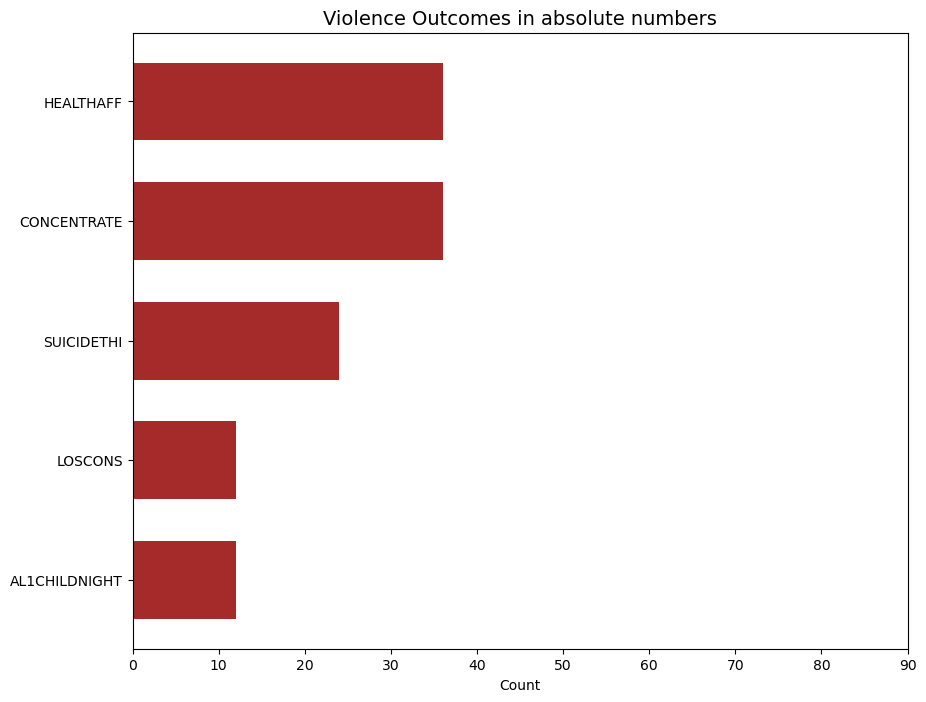

In [16]:
ax = y.value_counts(normalize=False, ascending=True).plot.barh(figsize=(10,8), width=.65, align="center",
                                                             color="brown")

ax.set_xticks(np.arange(0,100, 10))
ax.set_xlabel("Count")
ax.set_title("Violence Outcomes in absolute numbers", fontsize=14)
plt.show()

In [17]:
"""sns.catplot(x="ACTUALITY", y="OBS_VALUE", kind="violin", inner="point", bw="scott", palette="pastel", scale="count", data=df_train, width=.6,height=6, aspect=1.5) \
    .set(title="% Help value with Actuality")
plt.show()"""

'sns.catplot(x="ACTUALITY", y="OBS_VALUE", kind="violin", inner="point", bw="scott", palette="pastel", scale="count", data=df_train, width=.6,height=6, aspect=1.5)     .set(title="% Help value with Actuality")\nplt.show()'

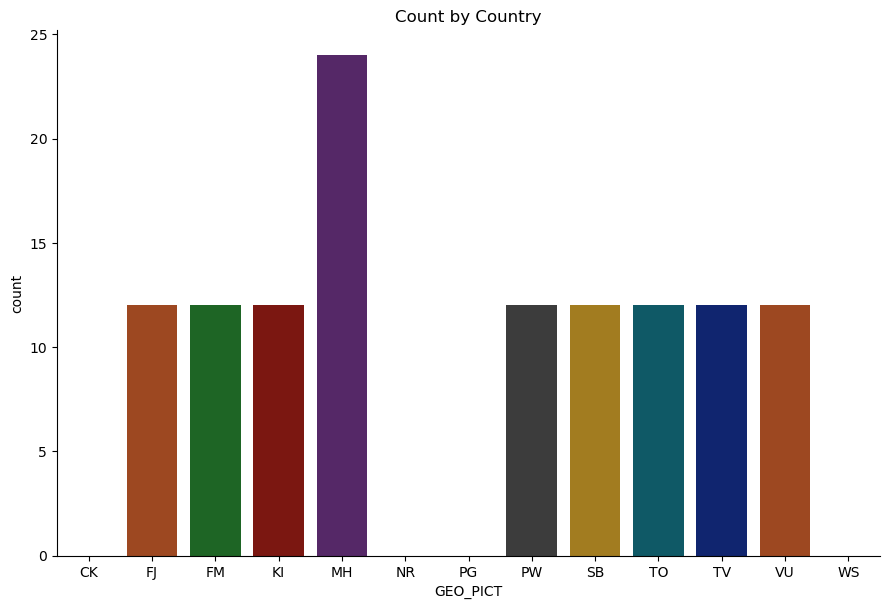

In [18]:
sns.catplot(x="GEO_PICT", data=df_train, palette="dark", kind="count", height=6, aspect=1.5) \
        .set(title="Count by Country")
plt.show()

In [19]:
# Prepare dataframe to print year only

year_df_train = year_df_train[year_df_train["OUTCOME"].notna()]
year_df_train["TIME_PERIOD"] = year_df_train["TIME_PERIOD"].dt.year.copy()

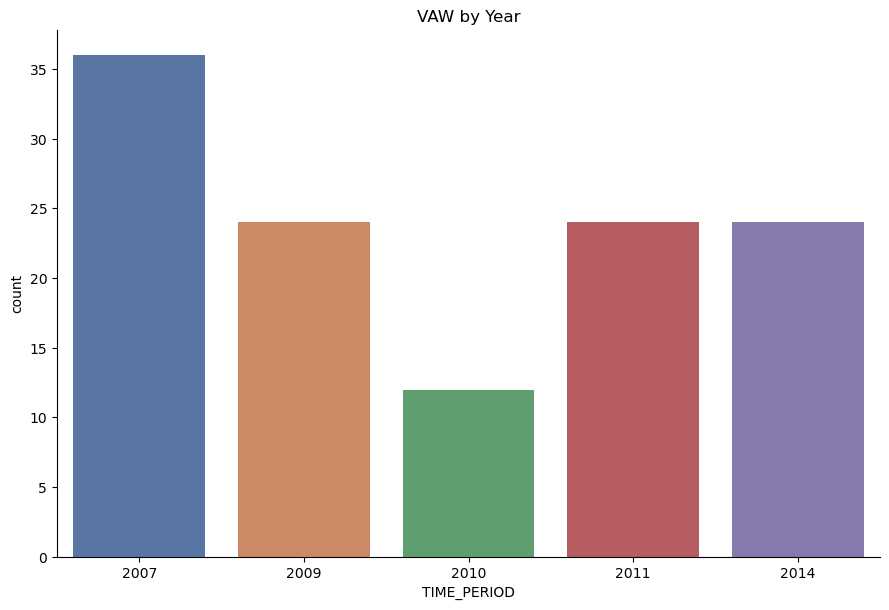

In [20]:
sns.catplot(x="TIME_PERIOD", data=year_df_train, palette="deep", kind="count", height=6, aspect=1.5) \
        .set(title="VAW by Year")
plt.show()

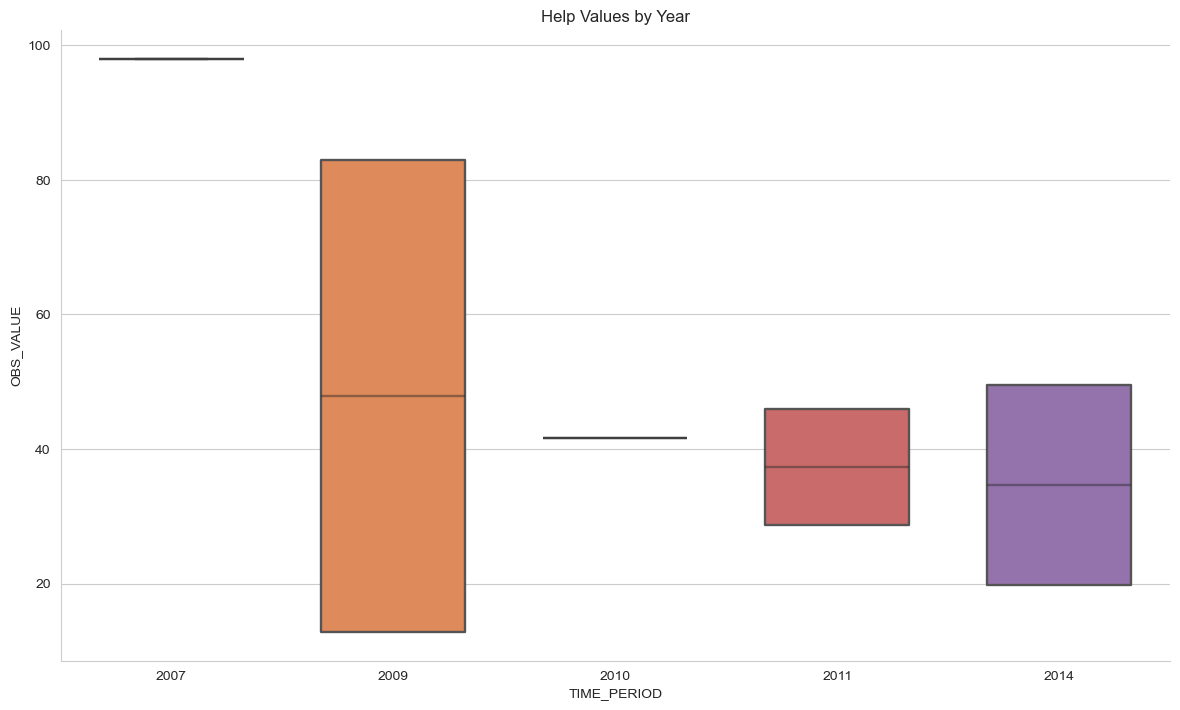

In [21]:
sns.set_style("whitegrid")
sns.catplot(x="TIME_PERIOD", y="OBS_VALUE", data=year_df_train, palette="muted", kind="boxen",
            height=7, aspect=1.7, width=.65,linewidth=1.7, saturation=0.8) \
        .set(title="Help Values by Year")
plt.show()

In [22]:
"""sns.catplot(kind="bar", x="HELP_REASON", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=6.5, aspect=1.1,
          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")

plt.title("Help value in conjuction with Help Reason", fontdict={'size':14, 'weight' : 'bold'})
plt.show()"""

'sns.catplot(kind="bar", x="HELP_REASON", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=6.5, aspect=1.1,\n          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")\n\nplt.title("Help value in conjuction with Help Reason", fontdict={\'size\':14, \'weight\' : \'bold\'})\nplt.show()'

In [23]:
"""sns.catplot(kind="bar", x="RESPONSE", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=8, aspect=1.1,
          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")

plt.title("Help value in conjuction with Woman's Response towards violence", fontdict={'size':14})
plt.show()"""

'sns.catplot(kind="bar", x="RESPONSE", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=8, aspect=1.1,\n          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")\n\nplt.title("Help value in conjuction with Woman\'s Response towards violence", fontdict={\'size\':14})\nplt.show()'

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=132, stratify=y)

In [25]:
# Impute values

imputer_numeric = SimpleImputer(strategy="median")

X_train["OBS_VALUE"] = imputer_numeric.fit_transform(X_train["OBS_VALUE"].values.reshape(-1,1))
X_test["OBS_VALUE"] = imputer_numeric.transform(X_test["OBS_VALUE"].values.reshape(-1,1))

In [26]:
# Fill NA categorical features with "NA"

imputer = SimpleImputer(strategy="constant", fill_value="NA")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test =  pd.DataFrame(imputer.transform(X_test), columns=X.columns)

In [27]:
# One-Hot encode and scale numeric values

categorical_cols = X.select_dtypes(exclude="float").columns
numeric_cols = X.select_dtypes(include="float").columns

col_transformer_train = ColumnTransformer([('cat_cols', OneHotEncoder(handle_unknown="ignore"), categorical_cols),
                                ('num_cols', StandardScaler(), numeric_cols)])

X_train = col_transformer_train.fit_transform(X_train).toarray()
X_test = col_transformer_train.transform(X_test).toarray()

In [28]:
# Label encoder y

le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Run ML Algos

##### Decision Trees

In [29]:
parameters = {'criterion':('gini', 'entropy'), 'max_features' : [20, 22, 24, 26], "min_samples_leaf":[1, 2],
             'max_depth':[3, 4, 5, 6], 'max_leaf_nodes':[8, 9, 10, 11, 15, 20], 
              'min_impurity_decrease':[1e-3, 5e-2, 1e-2]}

clf0 = GridSearchCV(DecisionTreeClassifier(random_state=132), parameters, scoring="f1_micro", n_jobs=2, verbose=1)

clf0.fit(X_train, y_train)

print(clf0.best_params_)
print(clf0.scorer_)
print("Best cv score", clf0.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf0.predict(X_test), average="micro"))

#clf = DecisionTreeClassifier(criterion="gini", random_state=132, max_features=23, min_samples_leaf=5, max_depth=6, 
#                                 max_leaf_nodes=15, min_impurity_decrease=.005)
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
{'criterion': 'gini', 'max_depth': 3, 'max_features': 20, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 1.0
F1 Score on held out data 1.0


In [30]:
print(classification_report(y_test, clf0.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

AL1CHILDNIGHT      1.000     1.000     1.000         3
  CONCENTRATE      1.000     1.000     1.000         9
    HEALTHAFF      1.000     1.000     1.000         9
      LOSCONS      1.000     1.000     1.000         3
   SUICIDETHI      1.000     1.000     1.000         6

     accuracy                          1.000        30
    macro avg      1.000     1.000     1.000        30
 weighted avg      1.000     1.000     1.000        30



##### Logistic Regression

In [31]:
clf1 = LogisticRegression(solver="liblinear", random_state=132, max_iter=100, C=.75, penalty="l1")

clf1.fit(X_train, y_train)

print("F1 Score on held out data", f1_score(y_test, clf1.predict(X_test), average="micro"))

F1 Score on held out data 1.0


In [32]:
print(classification_report(y_test, clf1.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

AL1CHILDNIGHT      1.000     1.000     1.000         3
  CONCENTRATE      1.000     1.000     1.000         9
    HEALTHAFF      1.000     1.000     1.000         9
      LOSCONS      1.000     1.000     1.000         3
   SUICIDETHI      1.000     1.000     1.000         6

     accuracy                          1.000        30
    macro avg      1.000     1.000     1.000        30
 weighted avg      1.000     1.000     1.000        30



##### Bagging

In [33]:
base = DecisionTreeClassifier(criterion="gini", random_state=132, max_features=23, min_samples_leaf=5, max_depth=6, 
                                 max_leaf_nodes=15, min_impurity_decrease=.005)

parameters = {'n_estimators':[25, 30, 35, 40, 50], 'max_samples' : [.60, .65, .7, .75, .8, .85, .9, 1],
              'max_features' :[.55, .65, .75, .85]}

clf2 = GridSearchCV(BaggingClassifier(base_estimator=base, random_state=132), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=5)

clf2.fit(X_train, y_train)

print(clf2.best_params_)
print(clf2.scorer_)
print("Best cv score", clf2.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf2.predict(X_test), average="micro"))

Fitting 5 folds for each of 160 candidates, totalling 800 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 394, in _fit
    all_results = Parallel(
  File

ValueError: max_features must be in (0, n_features]

In [ ]:
print(classification_report(y_test, clf2.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### Random Forest

In [ ]:
parameters = {'n_estimators':[90, 100, 110],'max_depth' : [9,10,11], 
              'max_leaf_nodes':[5, 10], 'max_features':["log2", 42],
              'max_samples':[.85, .9]}

clf3 = GridSearchCV(RandomForestClassifier(criterion="gini", random_state=132), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=10)

clf3.fit(X_train, y_train)

print(clf3.best_params_)
print(clf3.scorer_)
print("Best cv score", clf3.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf3.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf3.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### KNN

In [ ]:
parameters = {'n_neighbors':[40, 50, 60, 100, 130],'weights' : ('uniform', 'distance'), 
              'p':[1, 2], 'leaf_size':[10, 15, 20, 25, 30]}

clf4 = GridSearchCV(KNeighborsClassifier(algorithm="kd_tree"), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=5)

clf4.fit(X_train, y_train)

print(clf4.best_params_)
print(clf4.scorer_)
print("Best cv score", clf4.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf4.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf4.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### SVM

In [ ]:
parameters = {'kernel':('linear', 'sigmoid', 'poly'), 'C':[.1, .5, 1, 2, 15], "tol":[1e-2, 2e-3, 1e-3, 1e-4],
             'degree':[1,2,3]}

clf5 = GridSearchCV(SVC(random_state=132), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf5.fit(X_train, y_train)

print(clf5.best_params_)
print(clf5.scorer_)
print("Best cv score", clf5.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf5.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf5.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### Neural Networks

In [ ]:
parameters = {'activation':('logistic', 'tanh'), 'hidden_layer_sizes':((32,64),(64,64)),
             'learning_rate_init':[1e-5, 1e-4, 1e-3]}

clf6 = MLPClassifier(hidden_layer_sizes=(256,256), activation="logistic", learning_rate_init=3e-3,
                    max_iter=2000, random_state=42, tol=0.01)

clf6.fit(X_train, y_train)

print("F1 Score on held out data", f1_score(y_test, clf6.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf6.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### Gradient Boosting

In [ ]:
clf7 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,
                                subsample=.9, min_samples_split=10, 
                                 random_state=142, max_features=30,
                                max_depth=30)

clf7.fit(X_train, y_train)
print("F1 Score on held out data", f1_score(y_test, clf7.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf7.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### LDA

In [ ]:
parameters = {'solver':('lsqr', 'svd'), 'tol':[1e-5, 1e-4, 1e-3]}

clf8 = GridSearchCV(LinearDiscriminantAnalysis(), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf8.fit(X_train, y_train)

print(clf8.best_params_)
print(clf8.scorer_)
print("Best cv score", clf8.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf8.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf8.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### NuSVC

In [ ]:
parameters = {'nu' : [2e-3, 1e-3, 3e-3, 1e-1, .15], 'kernel':('poly','rbf','linear'),
             'tol':[1e-4, 1e-3, 1e-2]}

clf9 = GridSearchCV(NuSVC(random_state=142), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf9.fit(X_train, y_train)

print(clf9.best_params_)
print(clf9.scorer_)
print("Best cv score", clf9.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf9.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf9.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### XGBoost

In [ ]:
"""xgboost_params = {'objective':'binary:logistic', 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 1e-2,
                 'verbosity':0, 'booster':'gbtree', 'gamma': 1.25, 'random_state':142, 'eval_metric':'mlogloss',
                 'use_label_encoder' : (False)}

clf10 = MultiOutputClassifier(XGBClassifier(**xgboost_params), n_jobs=2)

clf10.fit(X_train, y_train[:, np.newaxis])

print("F1 Score on held out data", f1_score(y_test, clf10.predict(X_test), average="micro"))"""

In [ ]:
print(classification_report(y_test, clf10.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

##### AdaBoost

In [ ]:
adaboost_params = {'n_estimators' : [10, 20, 30, 40, 50, 75, 100], 'learning_rate' : [1e-2, 5e-2, 5e-1, 1e-1, 1,]}

clf11 = GridSearchCV(AdaBoostClassifier(random_state=132), 
                     adaboost_params, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf11.fit(X_train, y_train)

print(clf11.best_params_)
print(clf11.scorer_)
print("Best cv score", clf11.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf11.predict(X_test), average="micro"))

In [ ]:
print(classification_report(y_test, clf11.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

In [ ]:
# Define a classifier to use for predictions
# we choose the one with the highest accuracy, in our case the Random Forest (clf3)
best_classifier = max([(clf, clf.score(X_test, y_test.reshape(-1,1))) for clf in 
                        [clf0, clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, clf11]], key=lambda x : x[1])[0]

clf = best_classifier

In [ ]:
# HeatMap
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), 
                              y.cat.categories, y.cat.categories)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_df, annot=True, cmap="OrRd", annot_kws={'size':12},cbar=False, 
            linewidths=1.2, linecolor="lightgrey")
plt.show()

#### Predict unknown values

In [ ]:
df_unk = df[ df["OUTCOME"].isna() ].copy()

In [ ]:
# Follow the same pipeline as before to convert this dataframe to a format that can be passed in a classifier

X_unk = df_unk.drop(columns=["OUTCOME"])
X_unk_cp = X_unk.copy()

column_names = X_unk.columns

In [ ]:
X_unk = X_unk.drop(columns=["TIME_PERIOD"])
X_unk = X_unk[X.columns]

In [ ]:
X_unk["OBS_VALUE"] = imputer_numeric.transform(X_unk["OBS_VALUE"].values.reshape(-1,1))
X_unk = pd.DataFrame(imputer.transform(X_unk), columns=X_unk.columns)
X_unk = col_transformer_train.transform(X_unk).toarray()

In [ ]:
y_unk = le.inverse_transform(clf.predict(X_unk).ravel())

In [ ]:
predicted_df = pd.concat([X_unk_cp, pd.DataFrame(y_unk, index=X_unk_cp.index, 
                        columns=["PREDICTED_OUTCOME"])], axis="columns")

In [ ]:
ax = predicted_df["PREDICTED_OUTCOME"].value_counts(normalize=True, ascending=True).plot.barh(
                                                                            figsize=(10,8), width=.8)

ax.set_title("Predictions of Violence against Women",fontsize=15)
ax.set_xlabel("Predicted outcome of VAW in % of total cases with NA values", fontsize=12)

plt.show()

In [ ]:
# Write final DF with the predictions to a CSV file
try:
    predicted_df.to_csv("Predict_VAW.csv", na_rep="NA", float_format="%.2f", index=False, encoding="utf-8")
except IOError as e:
    print("ERROR when trying to write to file", e)